# Часть 1:получение метеоданных через PyOWM API

## 1. Доступ к pyown API

На первом этапе анализа мы получаем метеоданные по выбранному городу через `pyown API`.
Эта информация структурируется в словаре, а затем загружается в виде `DataFrame Pandas` для выполнения первичной обработки.

### импорт библиотек

In [1]:
import pyowm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdfkit

## 1.1. Установка API-ключа PyOWM и определение переменных

Здесь мы определяем API-ключ для доступа к сервису `OpenWeather`, а также ячейку с параметром `city` , которая прописывается в `Papermill`.

### Установка API-ключа

In [2]:
owm = pyowm.OWM('43230e425309640f29960a123f537173')

### Определение параметров по умолчанию:

In [3]:
city = 'Sao Paulo,BR'

## 1.2. Получение метеоданных по определенному городу

На данном этапе мы используем PyOWM для получения данных о городе и структурирования их сначала в словаре, а затем в `DataFrame`.

###  Инстанцирование объекта `forecast` и получение метеоданных о городе:

In [4]:
fc = owm.three_hours_forecast(city)
forecast = fc.get_forecast()

### Создание словаря для структурирования метеоданных по выбранному городу:

In [5]:
dict_forecast = {
 'datetime':[],
 'clouds':[],
 'humidity':[],
 'temp':[],
 'temp_max':[],
 'temp_min':[],
 'detailed_status':[],
 'icon_url':[],
 'rain_vol':[]
}

### Перебор объекта `forecast` для доступа к метеорологическим характеристикам (опциям):

In [6]:
for weather in forecast:
    dict_forecast['datetime'].append(str(weather.get_reference_time(timeformat='iso')))
    dict_forecast['clouds'].append(weather.get_clouds())    
    dict_forecast['humidity'].append(weather.get_humidity())
    dict_forecast['temp'].append(weather.get_temperature(unit='celsius').get('temp'))
    dict_forecast['temp_max'].append(weather.get_temperature(unit='celsius').get('temp_max'))
    dict_forecast['temp_min'].append(weather.get_temperature(unit='celsius').get('temp_min'))
    dict_forecast['detailed_status'].append(weather.get_detailed_status())
    dict_forecast['icon_url'].append(weather.get_weather_icon_url())
    if '3h' in weather.get_rain().keys():
        dict_forecast['rain_vol'].append(weather.get_rain().get('3h'))
    else:
        dict_forecast['rain_vol'].append(0)

### Создание `Dataframe` из словаря:

In [7]:
df = pd.DataFrame.from_dict(dict_forecast)

# Set dtype to datetime for 'datetime' column 
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

,datetime,clouds,humidity,temp,temp_max,temp_min,detailed_status,icon_url,rain_vol
0,2020-12-27 21:00:00+00:00,66,75,23.36,23.36,22.54,moderate rain,http://openweathermap.org/img/w/10d.png,7.37
1,2020-12-28 00:00:00+00:00,85,80,21.74,21.74,21.07,heavy intensity rain,http://openweathermap.org/img/w/10n.png,14.82
2,2020-12-28 03:00:00+00:00,96,76,21.07,21.07,20.86,light rain,http://openweathermap.org/img/w/10n.png,0.59
3,2020-12-28 06:00:00+00:00,100,81,20.16,20.16,20.13,overcast clouds,http://openweathermap.org/img/w/04n.png,0.00
4,2020-12-28 09:00:00+00:00,15,82,19.97,19.97,19.97,light rain,http://openweathermap.org/img/w/10d.png,0.25


In [8]:
# Create a dataframe agregating the values based on each day
# for mean
df_mean = df.resample('D', on='datetime').mean()
df_mean.index = df_mean.index.date
#df_mean.drop('datetime', axis=1, inplace=True)
df_mean

,clouds,humidity,temp,temp_max,temp_min,rain_vol
2020-12-27,66.000000,75.000000,23.36000,23.36000,22.54000,7.37000
2020-12-28,60.625000,67.250000,23.79250,23.79250,23.67875,3.44750
2020-12-29,67.750000,66.750000,24.23125,24.23125,24.23125,3.84750
2020-12-30,58.875000,62.750000,25.38250,25.38250,25.38250,2.76625
2020-12-31,23.250000,60.250000,25.98000,25.98000,25.98000,0.58250
2021-01-01,70.571429,69.714286,24.36000,24.36000,24.36000,0.75000


In [9]:
# for max
df_max = df.resample('D', on='datetime').max()
df_max.index = df_max.index.date
df_max.drop('datetime', axis=1, inplace=True)

df_max

,clouds,humidity,temp,temp_max,temp_min,detailed_status,icon_url,rain_vol
2020-12-27,66,75,23.36,23.36,22.54,moderate rain,http://openweathermap.org/img/w/10d.png,7.37
2020-12-28,100,82,28.64,28.64,28.64,overcast clouds,http://openweathermap.org/img/w/10n.png,14.82
2020-12-29,100,81,28.11,28.11,28.11,moderate rain,http://openweathermap.org/img/w/10n.png,7.33
2020-12-30,100,80,29.82,29.82,29.82,overcast clouds,http://openweathermap.org/img/w/10n.png,5.80
2020-12-31,73,72,31.01,31.01,31.01,scattered clouds,http://openweathermap.org/img/w/10n.png,2.40
2021-01-01,100,81,28.20,28.20,28.20,scattered clouds,http://openweathermap.org/img/w/10d.png,2.93


In [10]:
# for min
df_min = df.resample('D', on='datetime').min()
df_min.index = df_min.index.date
df_min.drop('datetime', axis=1, inplace=True)
df_min

,clouds,humidity,temp,temp_max,temp_min,detailed_status,icon_url,rain_vol
2020-12-27,66,75,23.36,23.36,22.54,moderate rain,http://openweathermap.org/img/w/10d.png,7.37
2020-12-28,10,46,19.97,19.97,19.97,clear sky,http://openweathermap.org/img/w/01d.png,0.00
2020-12-29,33,51,20.62,20.62,20.62,light rain,http://openweathermap.org/img/w/10d.png,0.28
2020-12-30,10,47,21.13,21.13,21.13,light rain,http://openweathermap.org/img/w/04n.png,0.00
2020-12-31,0,45,21.69,21.69,21.69,clear sky,http://openweathermap.org/img/w/01d.png,0.00
2021-01-01,31,53,21.86,21.86,21.86,broken clouds,http://openweathermap.org/img/w/03n.png,0.00


In [11]:
# Create a Dataframe with temperature values (min, max, average) by merging on index
df_temp = df_min[['temp']].merge(df_max[['temp']], 
                                 left_index=True, 
                                 right_index=True, 
                                 suffixes=('_min', '_max')).merge(df_mean[['temp']],
                                                                  left_index=True, 
                                                                  right_index=True)
# Rename columns
df_temp.columns = ['temp_min', 'temp_max', 'temp_mean']
df_temp

,temp_min,temp_max,temp_mean
2020-12-27,23.36,23.36,23.36000
2020-12-28,19.97,28.64,23.79250
2020-12-29,20.62,28.11,24.23125
2020-12-30,21.13,29.82,25.38250
2020-12-31,21.69,31.01,25.98000
2021-01-01,21.86,28.20,24.36000


# Часть 2: получение метеоданных через PyOWM API

Во второй части рабочего процесса мы объединяем данные по дням, а затем визуализируем информацию на двух графиках. Первый график показывает температурные данные, а второй — осадки, облачность и влажность.

## 2. Создание визуализации

На этом этапе мы будем создавать графики из структурированных данных через `seaborn`.

## 2.1. Температурный график
График показывает метеопрогноз с максимальной, минимальной и средней температурой на ближайшие 5 дней.

### Создание графика температур на ближайшие 5 дней

<ipython-input-12-ebb8aceacb92>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns_plot.set_xticklabels(df_temp.index, rotation=20)


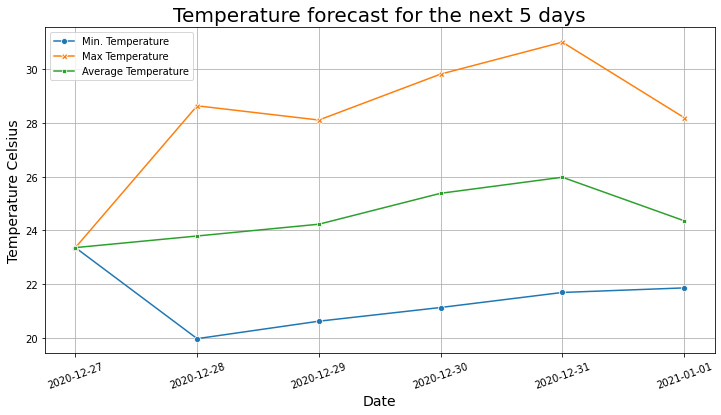

In [12]:
fig = plt.figure()
sns_plot = sns.lineplot(data=df_temp,markers=True, dashes=False)
sns_plot.set_title(f'Temperature forecast for the next 5 days', fontsize=20)
sns_plot.set_xlabel('Date', fontsize=14)
sns_plot.set_ylabel('Temperature Celsius', fontsize=14)
sns_plot.set_xticklabels(df_temp.index, rotation=20)
sns_plot.grid(True)

sns_plot.legend(labels=['Min. Temperature', 'Max Temperature', 'Average Temperature'])
fig.set_size_inches(12, 6)

temperature_plot = f"{city.split(',')[0].replace(' ','_')}_temperature.png"
sns_plot.figure.savefig(temperature_plot, 
                  dpi=300, facecolor='w', 
                  orientation='portrait',
                  bbox_inches='tight')

## 2.2. График влажности, осадков и облачности

В этом графике мы объединяем данные об осадках и влажности.

### Создание `Dataframe` с ожидаемым объемом осадков по дням:

In [13]:
df_rain_per_day = df.resample('D', on='datetime').sum()[['rain_vol']]
df_rain_per_day.index = df_rain_per_day.index.date

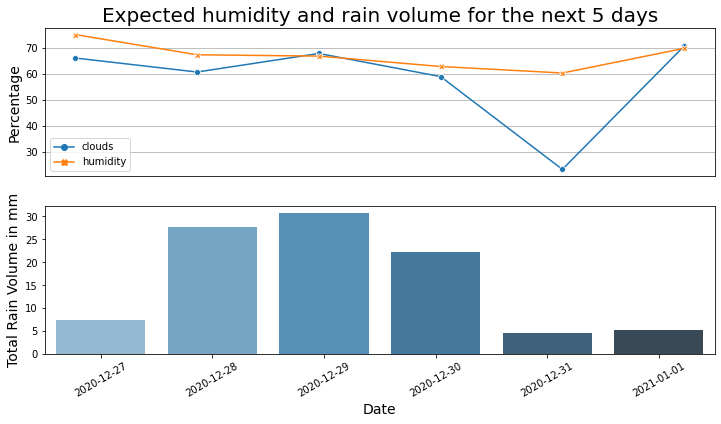

In [14]:
fig = plt.figure()
# Линейный график влажности и облачности:
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(data=df_mean[['clouds', 'humidity']], markers=True, dashes=False)
ax1.set_xticks([])
ax1.set_title(f'Expected humidity and rain volume for the next 5 days', fontsize=20)
ax1.set_ylabel('Percentage', fontsize=14)
ax1.grid(True)

# Столбцы с общим объемом осадков по дням:
ax2 = fig.add_subplot(212)
ax2 = sns.barplot(x=df_rain_per_day.index, y='rain_vol', 
                  data=df_rain_per_day,
                  palette="Blues_d")
ax2.set_xticklabels(df_temp.index, rotation=30)
ax2.set_ylabel('Total Rain Volume in mm', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
fig.set_size_inches(12, 6)

rain_humidity_plot = f"{city.split(',')[0].replace(' ','_')}_rain_humidity.png"
fig.savefig(rain_humidity_plot, 
              dpi=300, facecolor='w', 
              orientation='portrait',
              bbox_inches='tight')

# Часть 3: создание прогноза погоды в PDF
На последнем этапе рабочего процесса мы создаем общую метеорологическую сводку с использованием данных по городу и информации из графиков. Здесь нам понадобится библиотека `pdfkit`. С ее помощью мы сможем преобразовать HTML-шаблон в PDF-файл.

## 3. Создание метеосводки
На этом этапе рабочего процесса мы воспользуемся простым HTML-шаблоном и на его основе создадим итоговый отчет, куда добавим информацию о выбранном городе и наши графики.
### Задаем начальные и конечные даты для анализа:

In [15]:
today = str(df_mean.index.min()).replace('-', '/')
last_day = str(df_mean.index.max()).replace('-', '/')

### HTML-шаблон для добавления данных и графиков:

In [16]:
report_template = f'''
<!DOCTYPE html>
    <html>
      <head>
        <meta charset='utf-8'>
        <title>Weather Forecast with PyOWM</title>
        <link rel='stylesheet' href='report.css'>
          <style>
          h1 {{
          font-family: Arial;
          font-size: 300%;
          }}
          h2 {{
          font-family: Arial;
          font-size: 200%;
          }}
          @page {{
          size: 7in 9.25in;
          margin: 27mm 16mm 27mm 16mm;
          }}
          </style>                       
      </head>
      <h1 align="center">Weather forecast for {city}</h1>
      <h2 align="center">Initial date: {today}</h2>
      <h2 align="center">Final date: {last_day}</h2>
        
      <figure>
        <img src="{temperature_plot}" width="1200" height="600">
      </figure>
      <figure>
        <img src="{rain_humidity_plot}" width="1200" height="600">
      </figure>      
    </html>
'''

### Сохранение HTML-строки в файл:

In [17]:
html_report = f"{city.split(',')[0].replace(' ','_')}_report.html"
with open(html_report, "w") as r:
    r.write(report_template)

### Использование `pdfkit` для создания графика в PDF:

In [19]:
pdfkit.from_file(html_report, f"{city.split(',')[0].replace(' ', '_')}_weather_report_for.pdf")

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True

## Запуск
`papermill weather_forecast_using_pyowm.ipynb weather_forecast_using_pyowm_output.ipynb -p city "Moscow, RU"`